<a href="https://www.kaggle.com/code/zygimantasmarma/blood-estimation?scriptVersionId=113296062" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Steps on how to solve this problem:
1. Perform literature analysis on recommended papers [1-4] // TODO: add links at the end
1. Process (filter) ECG and FPG signals
1. Evaluate signal parameters PAT, PIR and HR [2]
1. Create a regression model evaluating systolic and diastolic blood pressure parameters
1. To quantify the effectiveness of the regression model
1. Create a classification model that classifies changes in systolic blood pressure into three categories: 
    *     Increase >10mmHg 
    *     Decrease < -10mmHg
    *     Insignificant changes (-10; 10) mmHg.
1. Evaluate the performen of the classification model (Acc, Spec, F1 ...)

Import needed libs:

In [597]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal

plt.rcParams['figure.figsize'] = [16, 8] # Matplotlib config

# This will show datasets paths TODO: delete after
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/zygimantasmarma/painlessdb/Painless021.mat


Load .mat data and covert to proper python arrays:

In [598]:
matData = scipy.io.loadmat('/kaggle/input/d/zygimantasmarma/painlessdb/Painless021.mat') # Specific data path for kaggle

print(type(matData))
print(matData)

bp = matData.get('bp')[0] # not sure why you get arrays of arrays
ecg = matData.get('ecg')[0] # note: this is 3x array
ecg_2 = matData.get('ecg')[1] # note: this is 3x array
ecg_3 = matData.get('ecg')[1] # note: this is 3x array

ppg = matData.get('ppg')[0]

f_bp = matData.get('f_bp')[0]
f_ecg = matData.get('f_ecg')[0]
f_ppg = matData.get('f_ppg')[0]

<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Nov  3 22:29:57 2022', '__version__': '1.0', '__globals__': [], 'bp': array([[72.81, 72.11, 71.56, ..., 70.3 , 71.16, 72.64]]), 'ecg': array([[-0.00082984, -0.00081711, -0.00081434, ..., -0.00232391,
        -0.00233045, -0.00232606],
       [-0.00209742, -0.00207858, -0.00207047, ...,  0.00073009,
         0.00072508,  0.00072484],
       [-0.00160103, -0.00159402, -0.00158911, ...,  0.00271969,
         0.0027215 ,  0.00271502]]), 'f_bp': array([[100]], dtype=uint8), 'f_ecg': array([[2000]], dtype=uint16), 'f_ppg': array([[1000]], dtype=uint16), 'ppg': array([[2087000, 2087268, 2087604, ..., 2396945, 2396970, 2396976],
       [1694830, 1695004, 1695136, ..., 1893987, 1893996, 1894017]],
      dtype=int32)}


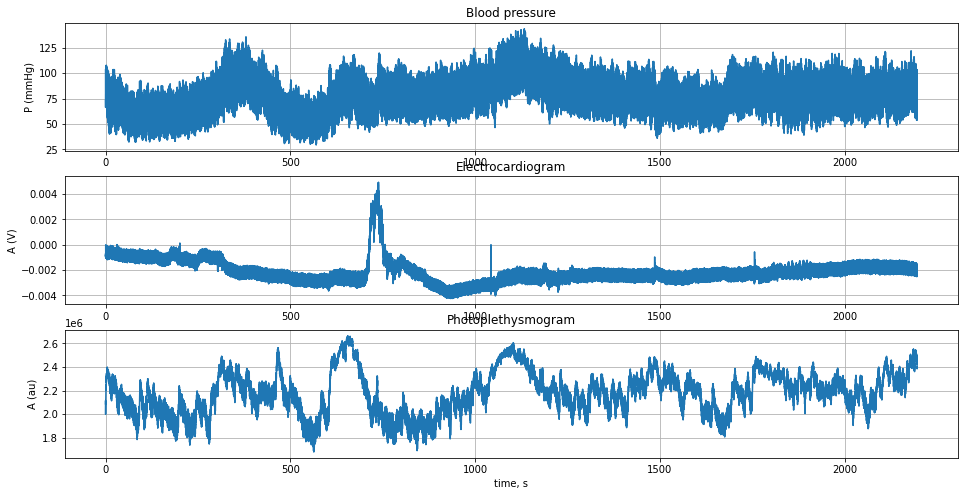

In [599]:
plt.figure()
plt.subplot(311)
time_bp = range(0, len(bp)) /f_bp
plt.plot(time_bp, bp)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg = range(0, len(ecg)) /f_ecg
plt.plot(time_ecg, ecg)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg = range(0, len(ppg)) /f_ppg
plt.plot(time_ppg, ppg)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()
plt.show()

Find features from unfiltered data *(not sure if needed)*. Finding SBP and DBP from peaks:

Find **MBP**:

Plot all 3 features on the same graph:

## Resample signals to same frequency

In [600]:
Fs = np.array([500])

bp_fs = signal.resample(bp, len(bp)*5) # 5 = 500 /100 TODO: fix


ecg_fs = signal.decimate(ecg, 4) #TODO: fix
timeEcg_fs = range(0, len(ecg_fs)) / Fs

ppg_fs = signal.decimate(ppg, 2) #TODO: fix
timePpg_fs = range(0, len(ppg_fs)) /Fs

## Create low-pass and high-pass filters

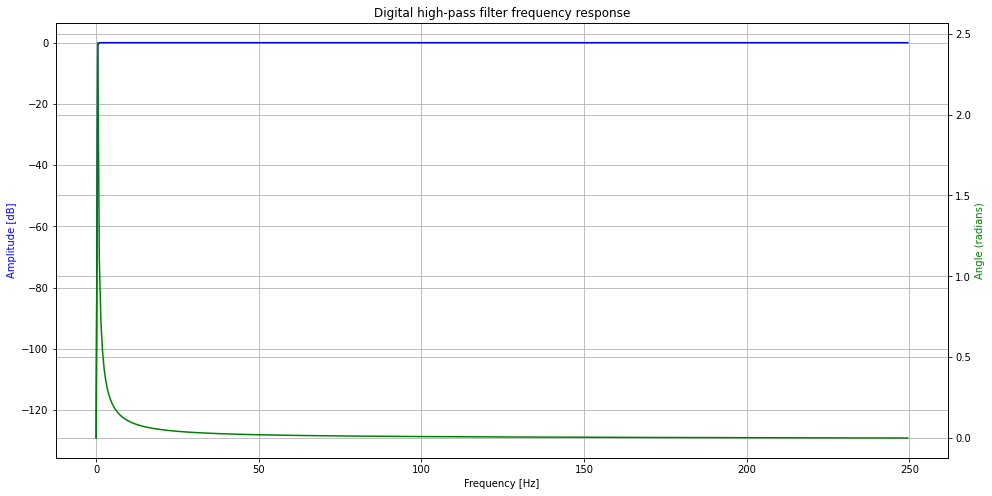

In [601]:
# Recommended filters values
f_co_hp = 0.5
f_co_lp = 17

b_highPass, a_highPass = signal.butter(4, (f_co_hp-0.1)/(Fs/2), btype = 'highpass')

w_1, h_1 = signal.freqz(b_highPass, a_highPass, fs=Fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital high-pass filter frequency response')
ax1.plot(w_1, 20 * np.log10(abs(h_1)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid(True)
ax2 = ax1.twinx()

angles = np.unwrap(np.angle(h_1))
ax2.plot(w_1, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

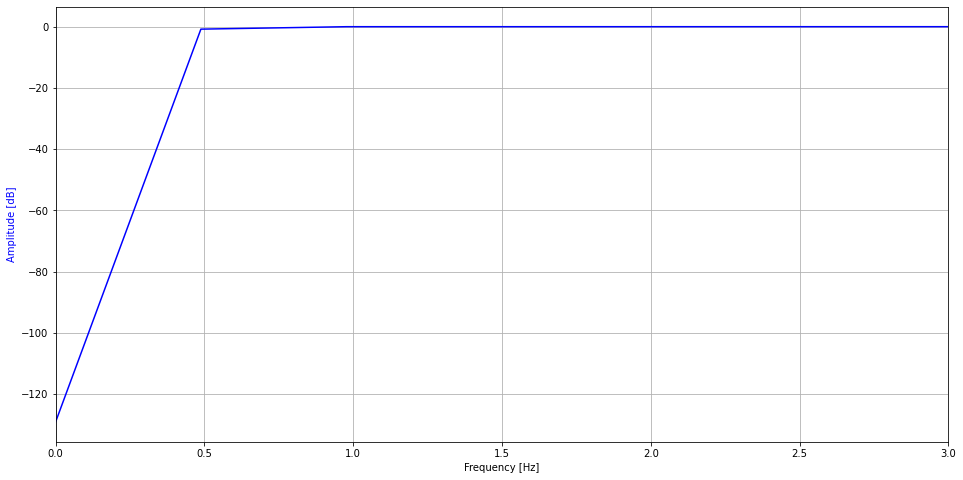

In [602]:
# Zoom in
plt.plot(w_1, 20 * np.log10(abs(h_1)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.xlim(0, 3.0)
plt.grid()
plt.show()

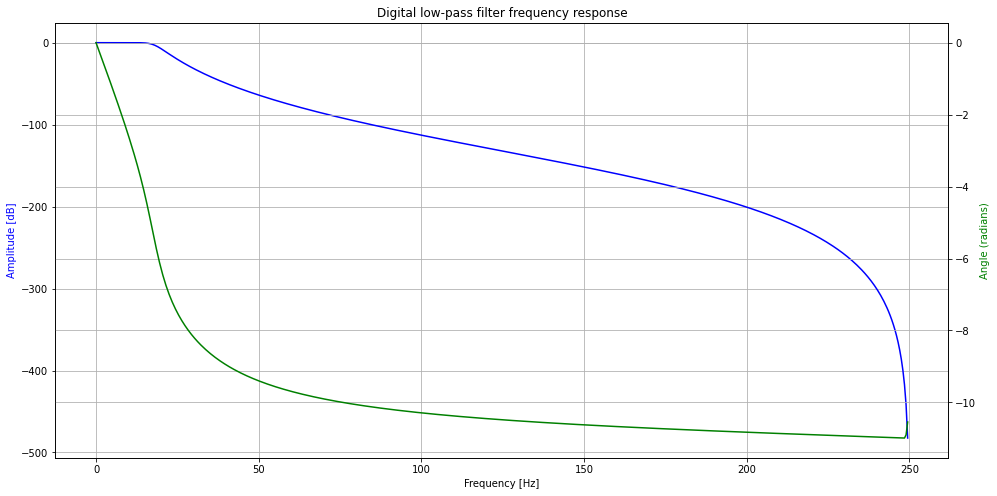

In [603]:
b_lowPass, a_lowPass = signal.butter(7, (f_co_lp+1)/(Fs/2), btype = 'lowpass')

w_2, h_2 = signal.freqz(b_lowPass, a_lowPass, fs=Fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital low-pass filter frequency response')
ax1.plot(w_2, 20 * np.log10(abs(h_2)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid(True)
ax2 = ax1.twinx()

angles = np.unwrap(np.angle(h_2))
ax2.plot(w_2, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')

ax2.axis('tight')
ax2.grid(True)
plt.show()

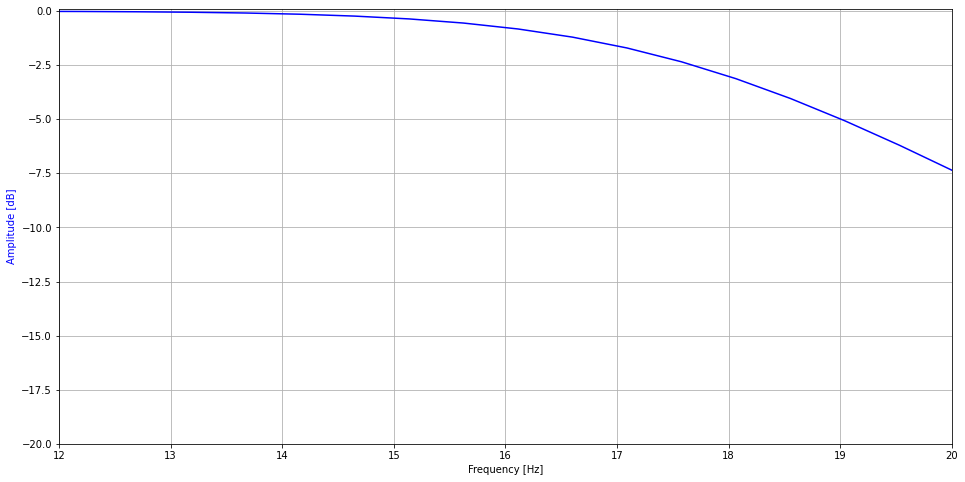

In [604]:
# Zoom in
plt.plot(w_2, 20 * np.log10(abs(h_2)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.xlim(12, 20.0)
plt.ylim(-20, 0.1)
plt.grid()
plt.show()

## Apply filters

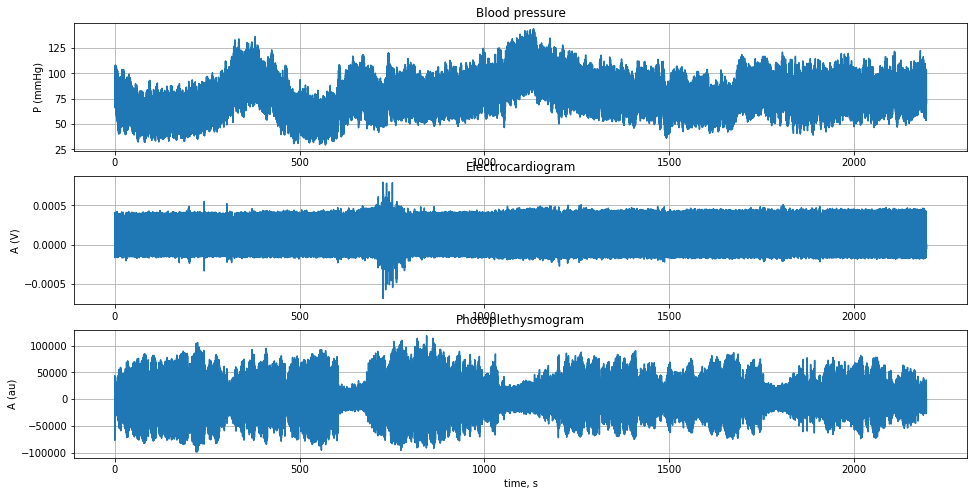

In [605]:
ecg_fs = signal.filtfilt(b_highPass, a_highPass, ecg_fs)
ppg_fs = signal.filtfilt(b_highPass, a_highPass, ppg_fs)

ecg_fs = signal.filtfilt(b_lowPass, a_lowPass, ecg_fs)
ppg_fs = signal.filtfilt(b_lowPass, a_lowPass, ppg_fs)

# Output
plt.figure()
plt.subplot(311)
time_bp_fs = range(0, len(bp_fs)) / Fs
plt.plot(time_bp_fs, bp_fs)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg_fs = range(0, len(ecg_fs)) / Fs
plt.plot(time_ecg_fs, ecg_fs)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg_fs = range(0, len(ppg_fs)) / Fs
plt.plot(time_ppg_fs, ppg_fs)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()

plt.show()

## Zoom in

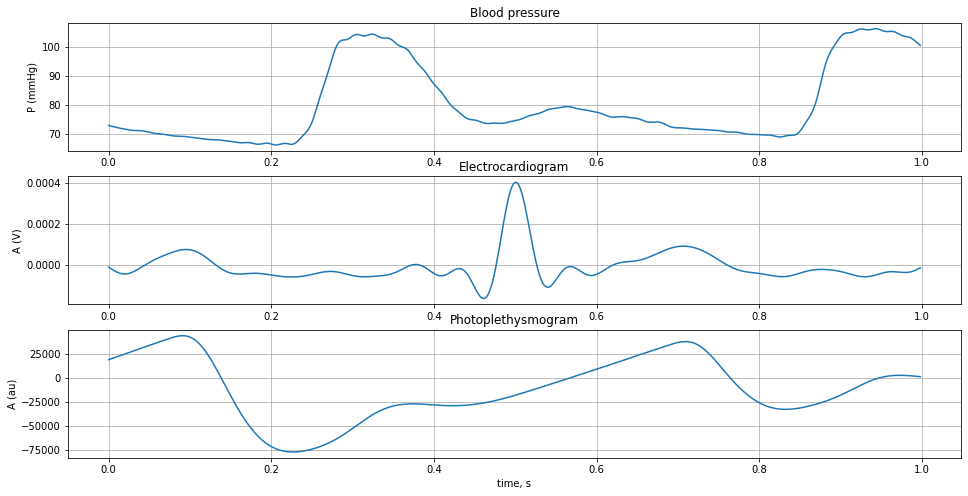

In [606]:
plt.figure()
plt.subplot(311)
time_bp_fs = range(0, len(bp_fs)) / Fs
plt.plot(time_bp_fs[:500], bp_fs[:500])
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg_fs = range(0, len(ecg_fs)) / Fs
plt.plot(time_ecg_fs[:500], ecg_fs[:500])
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg_fs = range(0, len(ppg_fs)) / Fs
plt.plot(time_ppg_fs[:500], ppg_fs[:500])
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()

plt.show()

## Extract the features from filtered and resampled signals

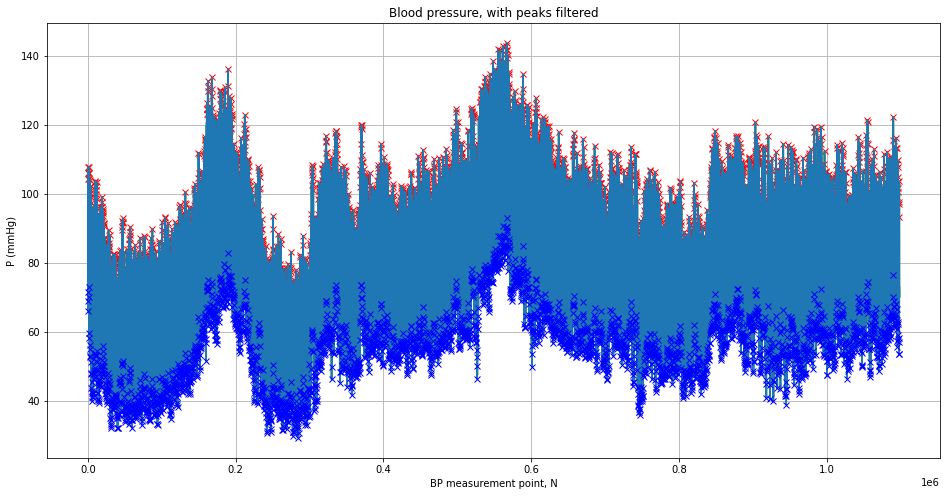

In [607]:
plt.figure()
locSBP_f, _ = find_peaks(bp_fs, distance=50*5)
plt.plot(bp_fs, "g")
plt.plot(locSBP_f, bp_fs[locSBP_f], "rx")

locDBP_f, _ = find_peaks(-bp_fs, distance=50*5)
plt.plot(bp_fs)
plt.plot(locDBP_f, bp_fs[locDBP_f], "bx")

plt.title('Blood pressure, with peaks filtered')
plt.ylabel('P (mmHg)')
plt.xlabel('BP measurement point, N')
plt.grid()

plt.show()

3235
3232


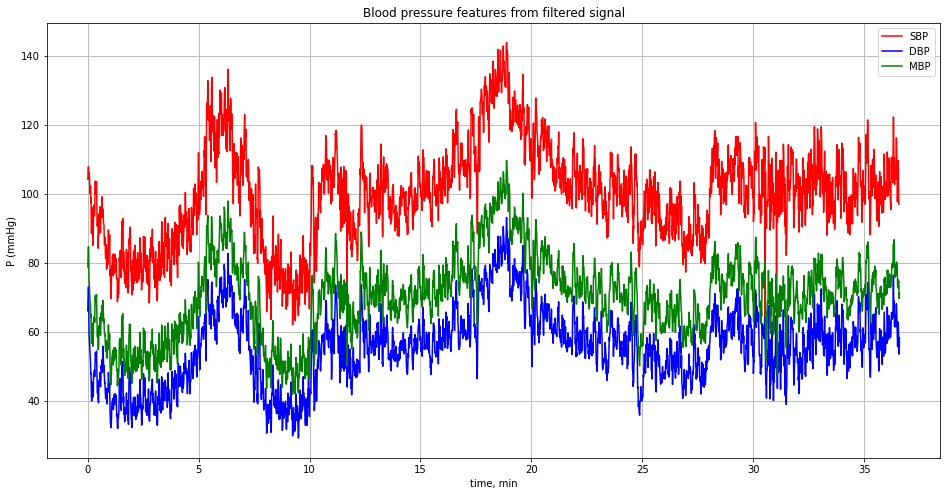

In [608]:
print(len(locSBP_f))
print(len(locDBP_f))

sigLen_fs = np.minimum(len(locSBP_f), len(locDBP_f)) #TODO: we really are just dropping data?

tempSBP_f = bp_fs[locSBP_f]
SBP_f = tempSBP_f[:sigLen_fs]
tempDBP_f= bp_fs[locDBP_f][:sigLen_fs]
DBP_f= tempDBP_f[:sigLen_fs]
MBP_f = (2*DBP_f + SBP_f) / 3


plt.figure()
t_SBP_f=locSBP_f[:sigLen_fs] / Fs;
plt.plot(t_SBP_f/60, SBP_f,'r', label='SBP')
# xlabel('beat No')

t_DBP_f=locDBP_f[:sigLen_fs] / Fs;
plt.plot(t_DBP_f/60, DBP_f,'b', label='DBP')

t_MBP_f = range(0, sigLen_fs) #TODO: check this
plt.plot(t_DBP_f/60, MBP_f,'g', label='MBP')
plt.legend()
plt.title('Blood pressure features from filtered signal')
plt.ylabel('P (mmHg)')
plt.xlabel('time, min')
plt.grid()

plt.show()

## Try to create regresssion model from raw data instead of features 

In [609]:
# Make regression with ANN

# output Y
print(f"Output is BP, which is array of {len(ppg_fs)}, some array values:")
print(bp_fs)

# inputs X
print(f"Input is ECG (length = {len(ecg_fs)}) and PPG (length = {len(ppg_fs)})")
print("ECG:")
print(ecg_fs)
print("PPG:")
print(ppg_fs)

# arrSize = 1097930
arrSize   = 750000
arrSizeVal= 250000
#### 
# ecg_fs = ecg_fs * 1000000


dataset = np.array([ecg_fs[:arrSize], ppg_fs[:arrSize]]).T
print("Dataset:")
print(dataset)
print(len(dataset))

X = dataset
Y = bp_fs[:arrSize]
print(X.shape)

dataset_val = np.array([ecg_fs[-arrSizeVal:], ppg_fs[-arrSizeVal:]]).T

X_val = dataset_val
Y_val = bp_fs[-arrSizeVal:]

Output is BP, which is array of 1097930, some array values:
[72.81       72.67413046 72.52293695 ... 72.92905059 72.95538239
 72.910429  ]
Input is ECG (length = 1097930) and PPG (length = 1097930)
ECG:
[-1.07289543e-05 -1.60540052e-05 -2.12755547e-05 ... -4.76290923e-05
 -4.70287875e-05 -4.64612582e-05]
PPG:
[18976.28484591 19547.89106935 20119.24960888 ...  -811.2869917
  -742.06584678  -677.36261115]
Dataset:
[[-1.07289543e-05  1.89762848e+04]
 [-1.60540052e-05  1.95478911e+04]
 [-2.12755547e-05  2.01192496e+04]
 ...
 [-3.35179632e-05 -1.64640794e+04]
 [-2.81592988e-05 -1.64985632e+04]
 [-2.23471755e-05 -1.65213335e+04]]
750000
(750000, 2)


In [610]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define base model
# create model
def baseline_model():
    model = Sequential()
    model.add(Dense(20, input_shape=(2,), kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [611]:
print(X)
print(Y)

[[-1.07289543e-05  1.89762848e+04]
 [-1.60540052e-05  1.95478911e+04]
 [-2.12755547e-05  2.01192496e+04]
 ...
 [-3.35179632e-05 -1.64640794e+04]
 [-2.81592988e-05 -1.64985632e+04]
 [-2.23471755e-05 -1.65213335e+04]]
[72.81       72.67413046 72.52293695 ... 51.25199882 51.2344556
 51.21900811]


In [612]:
# add additional dimension for lstm layer
# x_train = np.asarray(train_set["x data"].values))[..., None] 
# y_train = np.asarray(train_set["y data"]).astype(np.float32)

# x_train = np.asarray(X)[..., None] 
# x_val = np.asarray(X_val)[..., None] 
# print(x_train)

In [613]:
import tensorflow as tf
from tensorflow.keras import layers

# model_r = tf.keras.Sequential()

# model_r.add(layers.Embedding(input_dim=1000, output_dim=64))


# model_r.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
# ######

# model_r.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
# model_r.add(tf.keras.layers.LSTM(units=32))

# #######
# model_r.add(tf.keras.layers.Dense(units=10))

# model_r.compile(loss="mean_squared_error", optimizer="adam", metrics="mse")


# model_r.fit(x=x_train,y=Y,epochs=4)
# model_r.summary()



# Regression
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=10, batch_size=5, verbose=1)
# kfold = KFold(n_splits=10)
# results = cross_val_score(estimator, X, Y, cv=kfold, scoring='neg_mean_squared_error')
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [614]:
# # predictions = model_r.predict(x_val)
# # print(predictions)
# # print(Y_val)
# print(x_val_s[0])
# print(x_val_s[0].shape)
# print(x_val_s.shape)
# print(x_val_s[:].shape)
# # print(x_val_s.shape)

In [615]:
# print(x_val_s[0][0][0])
# print(len(x_val_s[:][0][:, 0]))
# print(x_val_s[:][0][:, 0])



In [616]:
from keras.layers import Input, TimeDistributed, LSTM
from keras.models import Model

print(X)
print(X.shape)
print(X.shape)

x_s = X.reshape((750, 1000, 2))

print("X after spillting")
print(x_s)
print(x_s.shape)


print("Y - outputs")
print(Y.shape)
y_s = Y.reshape((750, 1000))
print(y_s.shape)

[[-1.07289543e-05  1.89762848e+04]
 [-1.60540052e-05  1.95478911e+04]
 [-2.12755547e-05  2.01192496e+04]
 ...
 [-3.35179632e-05 -1.64640794e+04]
 [-2.81592988e-05 -1.64985632e+04]
 [-2.23471755e-05 -1.65213335e+04]]
(750000, 2)
(750000, 2)
X after spillting
[[[-1.07289543e-05  1.89762848e+04]
  [-1.60540052e-05  1.95478911e+04]
  [-2.12755547e-05  2.01192496e+04]
  ...
  [ 1.14362531e-05  2.71669020e+04]
  [ 1.50005957e-05  2.73918440e+04]
  [ 1.85382050e-05  2.76250040e+04]]

 [[ 2.20296339e-05  2.78668766e+04]
  [ 2.54638942e-05  2.81173358e+04]
  [ 2.88380875e-05  2.83755094e+04]
  ...
  [-1.99407902e-06  1.76739848e+04]
  [ 4.33208484e-07  1.78794955e+04]
  [ 2.34487234e-06  1.80861382e+04]]

 [[ 3.74675483e-06  1.82933827e+04]
  [ 4.67026514e-06  1.85005794e+04]
  [ 5.16890626e-06  1.87069798e+04]
  ...
  [-1.64218456e-05  9.23542947e+03]
  [-9.31106922e-06  9.50872937e+03]
  [-4.17573920e-06  9.78080510e+03]]

 ...

 [[-2.79937477e-05 -4.27478848e+04]
  [-2.86843265e-05 -4.250392

In [617]:
print(X_val.shape)
print(Y_val.shape)

x_val_s = X_val.reshape((250, 1000, 2))
y_val_s = Y_val.reshape((250, 1000))
print(x_val_s.shape)
print(y_val_s.shape)
# print(y_val_s[0])

(250000, 2)
(250000,)
(250, 1000, 2)
(250, 1000)


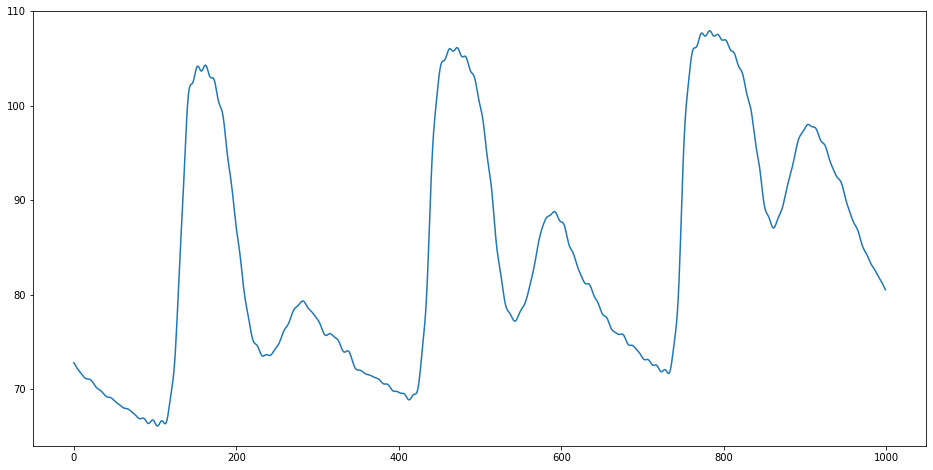

In [618]:
plt.plot(y_s[0])

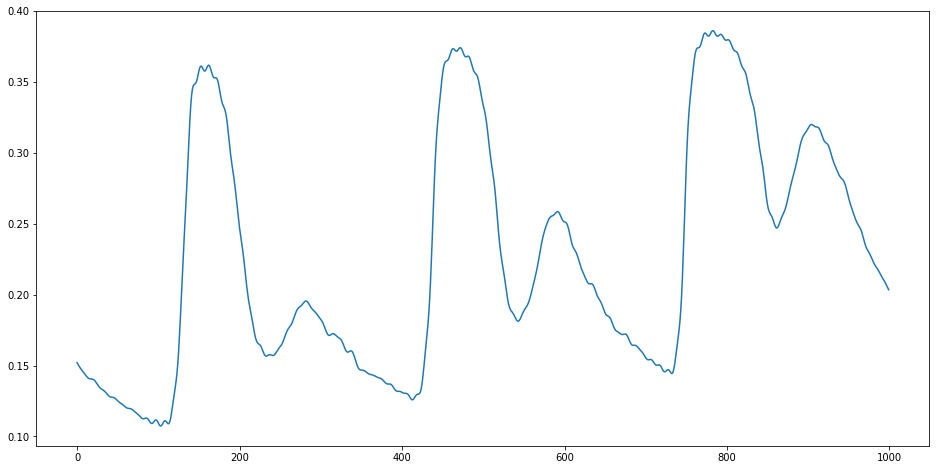

In [619]:
# LSTM needs this normalization for y (blood presure) in ~0-1?
norm_y_s = np.divide(np.subtract(y_s, 50), 150)
norm_y_val_s = np.divide(np.subtract(y_val_s, 50), 150)
plt.plot(norm_y_s[0])

In [620]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


inputs = Input(shape=(1000, 2))
encoder = LSTM(512, dropout=0.2, return_sequences=True)(inputs)
encoder_2 = LSTM(128, dropout=0.2, return_sequences=True)(encoder)
encoder_3 = LSTM(64, dropout=0.5,return_sequences=True)(encoder_2)
sequence_prediction = TimeDistributed(Dense(1, activation='linear'))(encoder_3) # ar relu su LSTM netinkamas
model_s = Model(inputs, sequence_prediction)
model_s.compile('adam', 'mse')
model_s.summary()
# model_s.fit(x_s, y_s, epochs=20, batch_size=64)

print(x_s.shape)
print(x_val_s.shape)


print(y_s.shape)
print(y_val_s.shape)

# model onlly works with normilized values
model_s.fit(x_s, norm_y_s, epochs=60, batch_size=32, validation_data=(x_val_s, norm_y_val_s), callbacks=[callback])


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 1000, 2)]         0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 1000, 512)         1054720   
_________________________________________________________________
lstm_55 (LSTM)               (None, 1000, 128)         328192    
_________________________________________________________________
lstm_56 (LSTM)               (None, 1000, 64)          49408     
_________________________________________________________________
time_distributed_75 (TimeDis (None, 1000, 1)           65        
Total params: 1,432,385
Trainable params: 1,432,385
Non-trainable params: 0
_________________________________________________________________
(750, 1000, 2)
(250, 1000, 2)
(750, 1000)
(250, 1000)
Epoch 1/60
24/24 [==============================] - 12s 367m

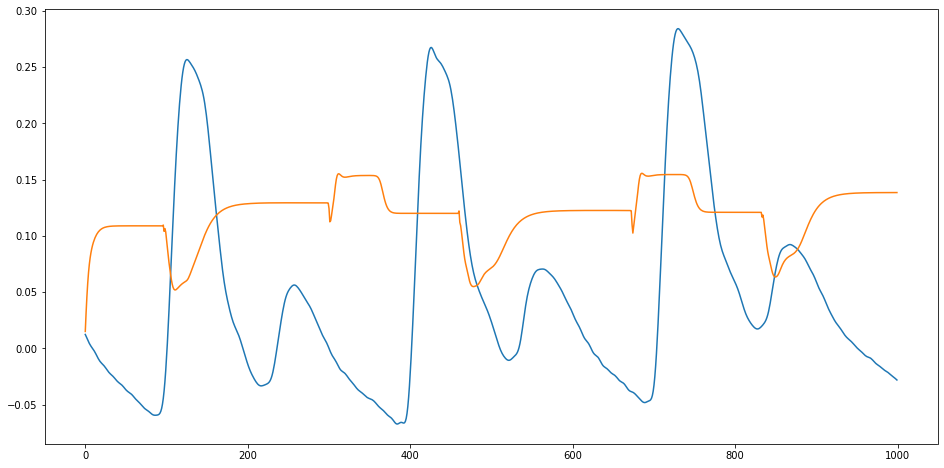

In [621]:
predictions = model_s.predict(x_val_s)
plt.plot(norm_y_s[5])
plt.plot(predictions[5])
# plt.plot(predictions[3])
     

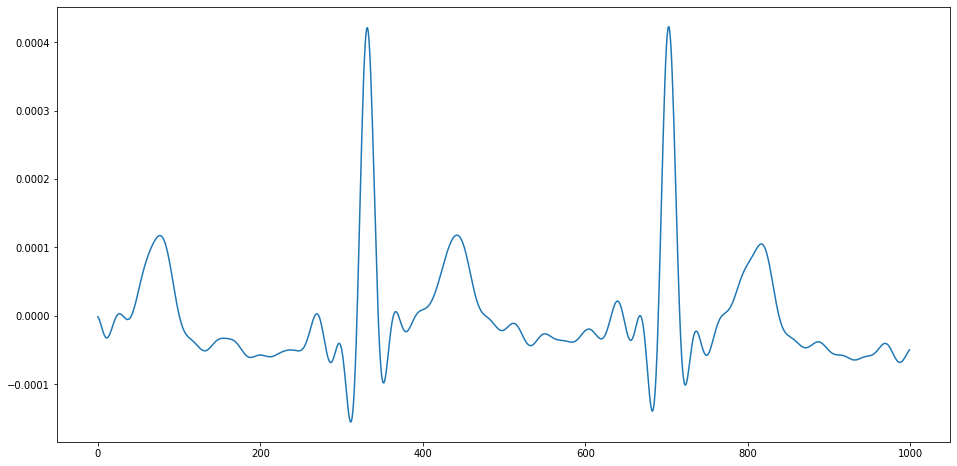

In [622]:
plt.plot(x_val_s[5][:,0])

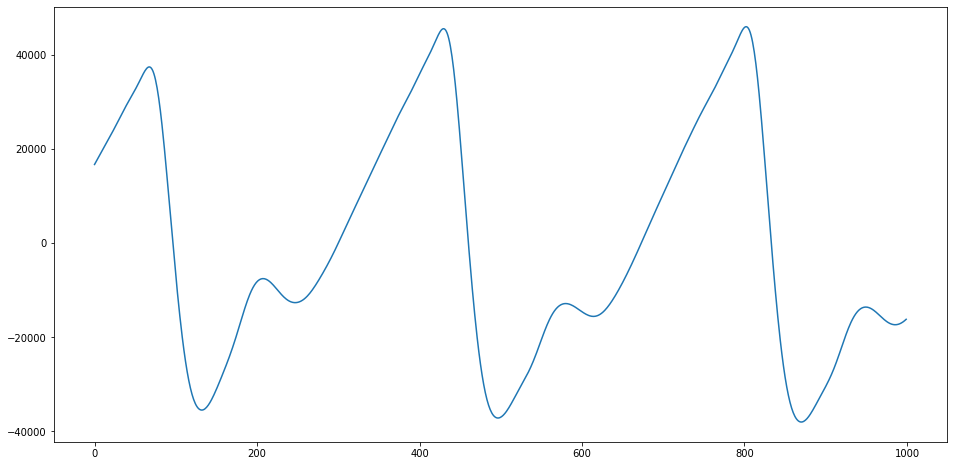

In [623]:
plt.plot(x_val_s[5][:,1])

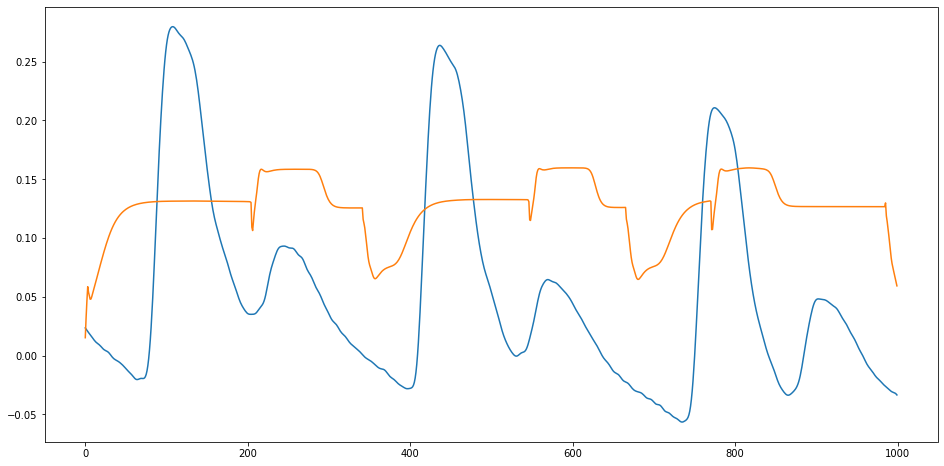

In [624]:
plt.plot(norm_y_s[100])
plt.plot(predictions[100])

## BP prediction from raw ECG and PPG

In [753]:
# A new lstm

from keras.applications.inception_v3 import InceptionV3
from keras.layers import Flatten, Dropout, Conv1D


model_in = Sequential([
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.BatchNormalization(),
#     Conv1D(32, 2, activation='relu'),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    Dropout(0.2),
    Dense(1) # last layer must be 1
])

model_f = Sequential()
#add Inception model for 8 input images (keeping the right shape)
model_f.add(TimeDistributed(model_in, input_shape=(1000, 2)))
# model_f.compile(optimizer='adam', loss='mse')
model_f.compile(optimizer='adam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())

model_f.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 1000, 1)           136705    
Total params: 136,705
Trainable params: 136,577
Non-trainable params: 128
_________________________________________________________________


In [761]:
# callback_f = (monitor='val_loss', patience=15)

callback_f = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.1,
    patience=35,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
model_f.fit(x_s, y_s, epochs=150, batch_size=16, validation_data=(x_val_s, y_val_s), callbacks=[callback_f])

Epoch 1/150
47/47 [==============================] - 1s 11ms/step - loss: 316.7490 - root_mean_squared_error: 17.7974 - val_loss: 238.6381 - val_root_mean_squared_error: 15.4479
Epoch 2/150
47/47 [==============================] - 0s 11ms/step - loss: 303.0481 - root_mean_squared_error: 17.4083 - val_loss: 366.2828 - val_root_mean_squared_error: 19.1385
Epoch 3/150
47/47 [==============================] - 1s 12ms/step - loss: 313.1380 - root_mean_squared_error: 17.6957 - val_loss: 408.0767 - val_root_mean_squared_error: 20.2009
Epoch 4/150
47/47 [==============================] - 1s 11ms/step - loss: 348.8499 - root_mean_squared_error: 18.6775 - val_loss: 274.3944 - val_root_mean_squared_error: 16.5649
Epoch 5/150
47/47 [==============================] - 0s 10ms/step - loss: 311.4559 - root_mean_squared_error: 17.6481 - val_loss: 252.9355 - val_root_mean_squared_error: 15.9039
Epoch 6/150
47/47 [==============================] - 0s 10ms/step - loss: 307.3847 - root_mean_squared_error: 

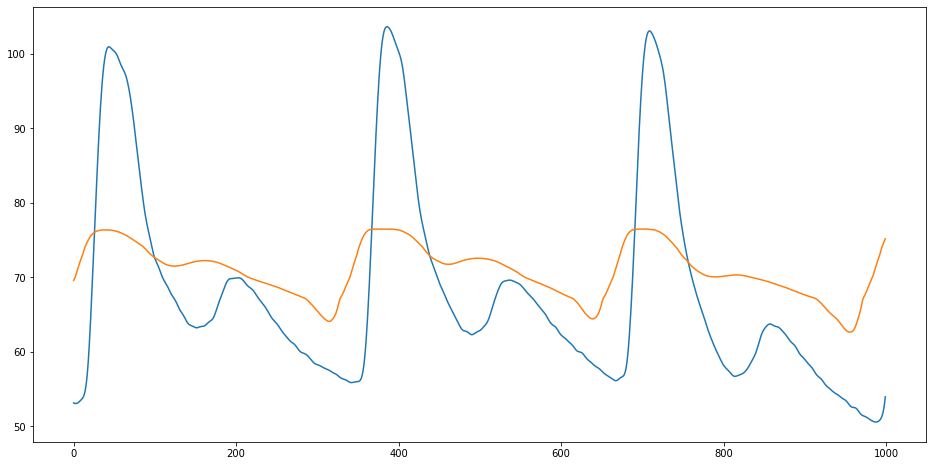

In [762]:
predictions = model_f.predict(x_val_s)
# print(predictions)
plt.plot(y_val_s[100])
plt.plot(predictions[100])

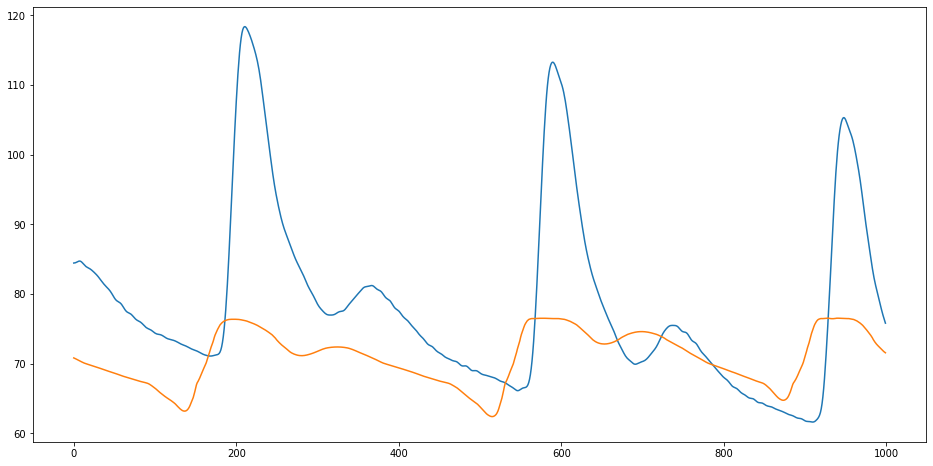

In [763]:
plt.plot(y_val_s[0])
plt.plot(predictions[0])

## There is a problem with BP offset (model somewhy cant predict that) 

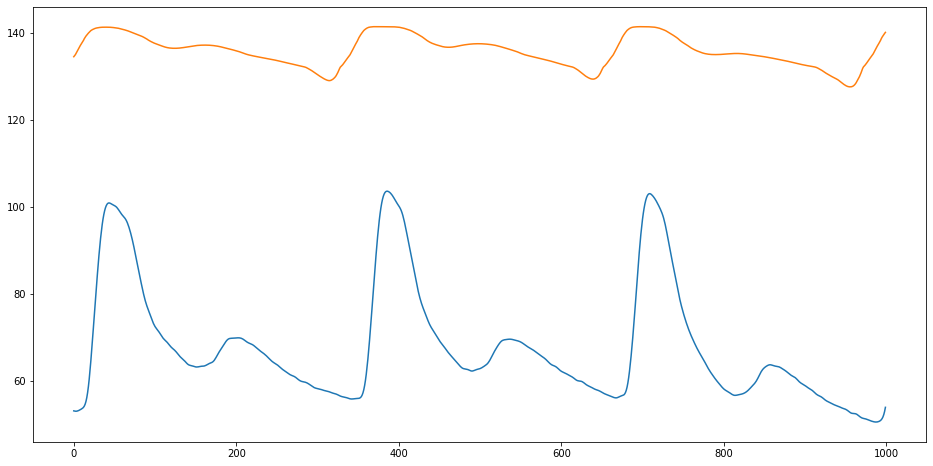

In [764]:
plt.plot(y_val_s[100])
plt.plot(predictions[100]+65)

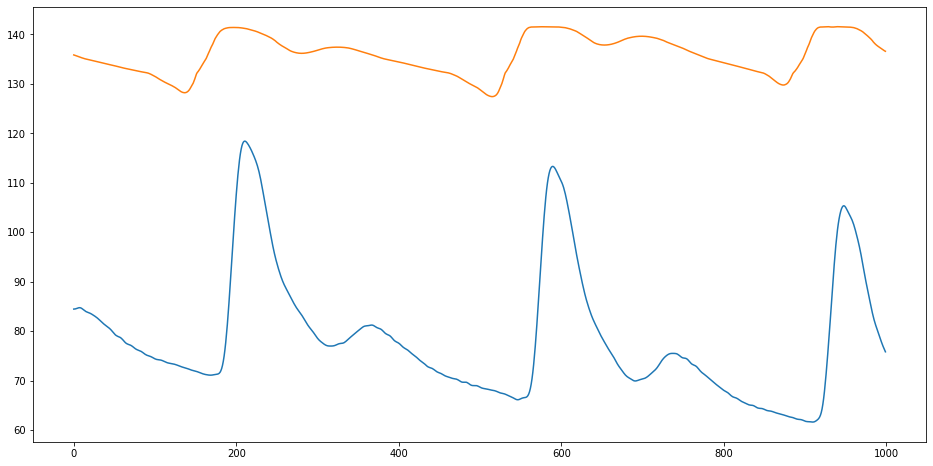

In [765]:
plt.plot(y_val_s[0])
plt.plot(predictions[0]+65)

## With Normalized

In [718]:
# same model with normalized BP
tf.keras.backend.clear_session()
model_in = Sequential([
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1) # last layer must be 1
])

# model_in.summary()
model_f = Sequential()
model_f.add(TimeDistributed(model_in, input_shape=(1000, 2)))

# model_f.compile(optimizer='adam', loss='mse')
# model_f.compile(optimizer='adam', loss='mse')
model_f.compile(optimizer='adam', loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())


callback_f = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)
model_f.fit(x_s, norm_y_s, epochs=150, batch_size=48, validation_data=(x_val_s, norm_y_val_s), callbacks=[callback_f])


Epoch 1/150
16/16 [==============================] - 1s 31ms/step - loss: 205146.8594 - root_mean_squared_error: 452.9314 - val_loss: 133.1872 - val_root_mean_squared_error: 11.5407
Epoch 2/150
16/16 [==============================] - 0s 18ms/step - loss: 4293.5791 - root_mean_squared_error: 65.5254 - val_loss: 3.9863 - val_root_mean_squared_error: 1.9966
Epoch 3/150
16/16 [==============================] - 0s 18ms/step - loss: 1292.4232 - root_mean_squared_error: 35.9503 - val_loss: 0.7597 - val_root_mean_squared_error: 0.8716
Epoch 4/150
16/16 [==============================] - 0s 18ms/step - loss: 707.2532 - root_mean_squared_error: 26.5942 - val_loss: 3.4407 - val_root_mean_squared_error: 1.8549
Epoch 5/150
16/16 [==============================] - 0s 18ms/step - loss: 460.1146 - root_mean_squared_error: 21.4503 - val_loss: 8.0569 - val_root_mean_squared_error: 2.8385
Epoch 6/150
16/16 [==============================] - 0s 18ms/step - loss: 294.3803 - root_mean_squared_error: 17.157

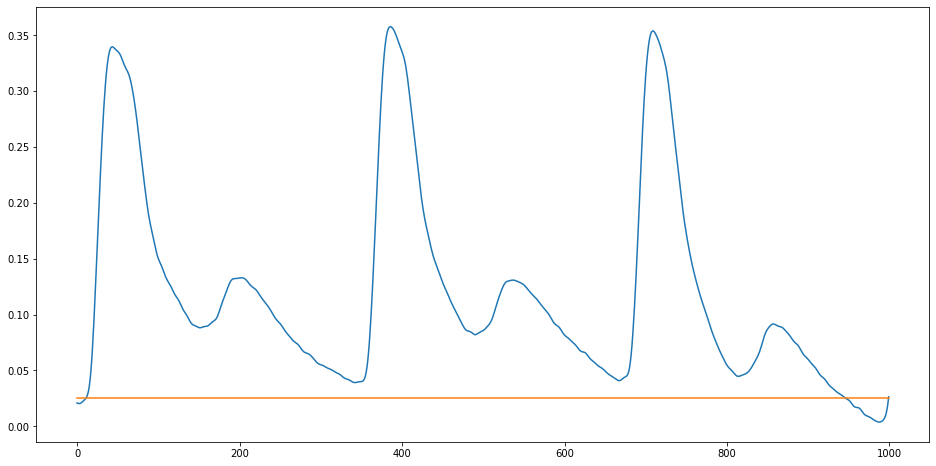

In [719]:
predictions_n = model_f.predict(x_val_s)
# print(predictions)
plt.plot(norm_y_val_s[100])
plt.plot(predictions_n[100])

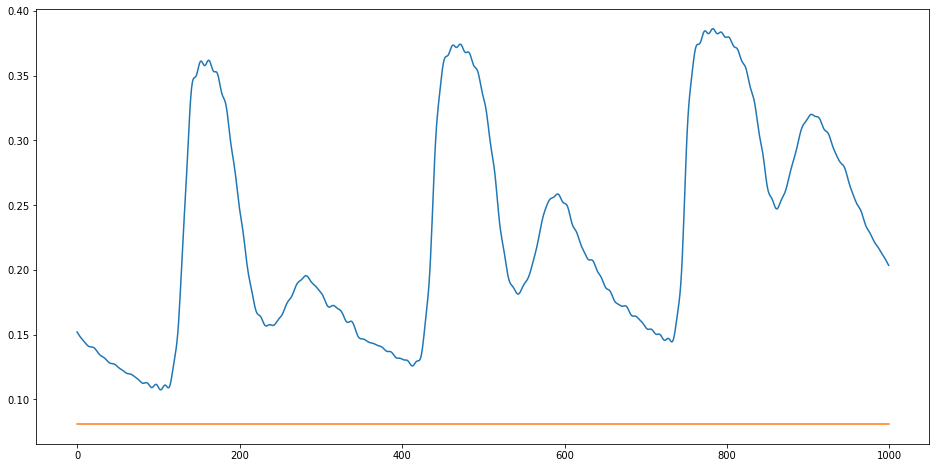

In [711]:
predictions_n = model_f.predict(x_val_s)
# print(predictions)
plt.plot(norm_y_val_s[0])
plt.plot(predictions_n[0])